# Generating the Dataset for the Whole City

## Problem
The City Economist's data only covered the parcels in San Francisco which were affected by the Family Zoning plan, so in order to do Fantasy Zoning across the entire city, we need to backwards-engineer the relevant inputs for the model for the parcels that are not in the City Economist's dataset.

## Datasets Used
- City Economist's data (https://github.com/dbroockman/bluesky-2025/tree/main) (private repo)
- active-and-retired-parcels.csv https://data.sfgov.org/Geographic-Locations-and-Boundaries/Parcels-Active-and-Retired/acdm-wktn/about_data, last udpated Dec 25, 2025
- land-use.csv (https://data.sfgov.org/Geographic-Locations-and-Boundaries/San-Francisco-Land-Use-2023/fdfd-xptc/about_data) last updated Apr 4, 2024
- height-and-bulk-districts.csv (https://data.sfgov.org/Geographic-Locations-and-Boundaries/Zoning-Map-Height-and-Bulk-Districts/h9wh-cg3m/about_data) last updated Dec 25, 2025
- zoning-districts.csv (https://data.sfgov.org/Geographic-Locations-and-Boundaries/Zoning-Map-Zoning-Districts/3i4a-hu95/about_data) Last updated Dec 25, 2025
- historic-districts.csv https://data.sfgov.org/Geographic-Locations-and-Boundaries/Historic-Districts/63x5-g3m4/about_data Last updated Dec 25, 2025

## Misc
- City Economist's report (https://drive.google.com/file/d/1Ua4admMow-OPSwTEqYe8JdGOYh5ne8Ot/view?usp=sharing), particularly pages 35-37 with the mapping of zoning code to zp_* attribute

## Load the Data

Load all source data files once into memory. These raw dataframes should be referenced but never modified.

In [339]:
import pandas as pd
import geopandas as gpd
from collections import Counter
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np

raw_parcels_df = pd.read_csv('active-and-retired-parcels.csv', dtype=str)
print(f'raw_parcels_df (active-and-retired-parcels.csv): {len(raw_parcels_df):,} rows')

raw_model_df = pd.read_csv('input/parcels-w-fzp-model-data.csv', dtype=str)
print(f'raw_model_df (parcels-w-fzp-model-data.csv): {len(raw_model_df):,} rows')

raw_public_parcels_df = gpd.read_file('../public/data/public-parcels.geojson')
print(f'raw_public_parcels_df (public-parcels.geojson): {len(raw_public_parcels_df):,} rows')

raw_land_use_df = pd.read_csv('input/land-use.csv', dtype=str)
print(f'raw_land_use_df (land-use.csv): {len(raw_land_use_df):,} rows')

raw_zoning_district_df = pd.read_csv('input/zoning-district.csv', dtype=str)
raw_zoning_district_gdf = gpd.GeoDataFrame(
    raw_zoning_district_df,
    geometry=gpd.GeoSeries.from_wkt(raw_zoning_district_df['the_geom']),
    crs='EPSG:4326'
)
print(f'raw_zoning_district_gdf (zoning-district.csv): {len(raw_zoning_district_gdf):,} rows')

parcels_df = raw_parcels_df.copy()

raw_parcels_df (active-and-retired-parcels.csv): 236,819 rows
raw_model_df (parcels-w-fzp-model-data.csv): 92,722 rows
raw_public_parcels_df (public-parcels.geojson): 1,871 rows
raw_land_use_df (land-use.csv): 154,476 rows
raw_zoning_district_gdf (zoning-district.csv): 1,652 rows


## Clean Up Parcel Data

### Deduplicate by Mapblklot

For each mapblklot, we keep the first row as "canonical" and aggregate all associated blklots into a `blklots` column.

In [340]:
mapblklot_to_blocklots = raw_parcels_df.groupby('mapblklot')['blklot'].apply(set).to_dict()

multi_blocklot_count = sum(1 for blklots in mapblklot_to_blocklots.values() if len(blklots) > 1)
total_mapblklots = len(mapblklot_to_blocklots)

print(f'Total unique mapblklots: {total_mapblklots:,}')
print(f'Mapblklots with multiple blocklots: {multi_blocklot_count:,} ({multi_blocklot_count/total_mapblklots*100:.1f}%)')
print(f'Mapblklots with single blocklot: {total_mapblklots - multi_blocklot_count:,} ({(total_mapblklots - multi_blocklot_count)/total_mapblklots*100:.1f}%)')

distribution = Counter(len(blklots) for blklots in mapblklot_to_blocklots.values())
six_plus = sum(num for count, num in distribution.items() if count >= 6)

print(f'\nDistribution of blocklots per mapblklot:')
for count in range(1, 6):
    print(f'  {count} blocklot(s): {distribution[count]:,} mapblklots')
print(f'  6+ blocklot(s): {six_plus:,} mapblklots')

Total unique mapblklots: 163,163
Mapblklots with multiple blocklots: 9,462 (5.8%)
Mapblklots with single blocklot: 153,701 (94.2%)

Distribution of blocklots per mapblklot:
  1 blocklot(s): 153,701 mapblklots
  2 blocklot(s): 4,959 mapblklots
  3 blocklot(s): 1,829 mapblklots
  4 blocklot(s): 884 mapblklots
  5 blocklot(s): 155 mapblklots
  6+ blocklot(s): 1,635 mapblklots


In [341]:
print(f'Loaded {len(parcels_df):,} rows')

blklots_agg = parcels_df.groupby('mapblklot')['blklot'].apply(lambda x: ','.join(sorted(x))).reset_index()
blklots_agg.columns = ['mapblklot', 'blklots']

parcels_df = parcels_df.drop_duplicates(subset='mapblklot', keep='first')
parcels_df = parcels_df.drop(columns=['blklot', 'block_num', 'lot_num'])
parcels_df = parcels_df.merge(blklots_agg, on='mapblklot')

cols = parcels_df.columns.tolist()
cols.remove('blklots')
cols.insert(1, 'blklots')
parcels_df = parcels_df[cols]

print(f'Deduplicated to {len(parcels_df):,} rows')

Loaded 236,819 rows
Deduplicated to 163,163 rows


### Fill Missing Addresses from Land Use Data

Fill in missing address fields (from_address_num, street_name, street_type) from land-use.csv.

In [342]:
missing_address_mask = parcels_df['from_address_num'].isna() | (parcels_df['from_address_num'] == '')
print(f'Parcels missing address: {missing_address_mask.sum():,}')

address_lookup = raw_land_use_df.set_index('mapblklot')[['from_st', 'street', 'st_type']].to_dict('index')

filled_count = 0
for idx in parcels_df[missing_address_mask].index:
    mapblklot = parcels_df.loc[idx, 'mapblklot']
    if mapblklot in address_lookup:
        addr = address_lookup[mapblklot]
        parcels_df.loc[idx, 'from_address_num'] = addr['from_st']
        parcels_df.loc[idx, 'street_name'] = addr['street']
        parcels_df.loc[idx, 'street_type'] = addr['st_type']
        filled_count += 1

print(f'Filled {filled_count:,} addresses from land-use.csv')
still_missing = (parcels_df['from_address_num'].isna() | (parcels_df['from_address_num'] == '')).sum()
print(f'Still missing address: {still_missing:,}')

Parcels missing address: 11,110
Filled 2,854 addresses from land-use.csv
Still missing address: 10,940


### Merge Model Data into Parcels Data, Remove Inactive Parcels

Merge `model_df` data into `parcels_df` by matching BlockLot to any blklot in the blklots column.

For some reason, model_df has parcels that are no longer active. So we keep parcels that have model data OR are active.

In [343]:
model_blklots = set(raw_model_df['BlockLot'])
parcels_blklots = set(raw_parcels_df['blklot'])

model_only = model_blklots - parcels_blklots
print(f'Model rows not in parcels data (discarded): {len(model_only):,}')

blklot_to_mapblklot = raw_parcels_df.set_index('blklot')['mapblklot'].to_dict()
raw_model_df_filtered = raw_model_df[raw_model_df['BlockLot'].isin(parcels_blklots)].copy()
raw_model_df_filtered['mapblklot'] = raw_model_df_filtered['BlockLot'].map(blklot_to_mapblklot)

model_cols = [c for c in raw_model_df_filtered.columns if c not in ['BlockLot']]
model_by_mapblklot = raw_model_df_filtered.drop_duplicates(subset='mapblklot', keep='first')[model_cols]

before_count = len(parcels_df)
parcels_df = parcels_df.merge(model_by_mapblklot, on='mapblklot', how='left')

has_model_data = parcels_df['mapblklot'].isin(model_by_mapblklot['mapblklot'])
is_active = parcels_df['active'] == 'true'
keep_mask = has_model_data | is_active

parcels_df = parcels_df[keep_mask]

print(f'Filtered from {before_count:,} to {len(parcels_df):,} parcels')
print(f'  - Has model data: {has_model_data.sum():,}')
print(f'  - Is active: {is_active.sum():,}')
print(f'  - Kept (either condition): {keep_mask.sum():,}')

Model rows not in parcels data (discarded): 3
Filtered from 163,163 to 155,122 parcels
  - Has model data: 92,717
  - Is active: 155,067
  - Kept (either condition): 155,122


### Sanity Check: Look at Map of Parcels with Model Data

Red = has model data, White = no model data

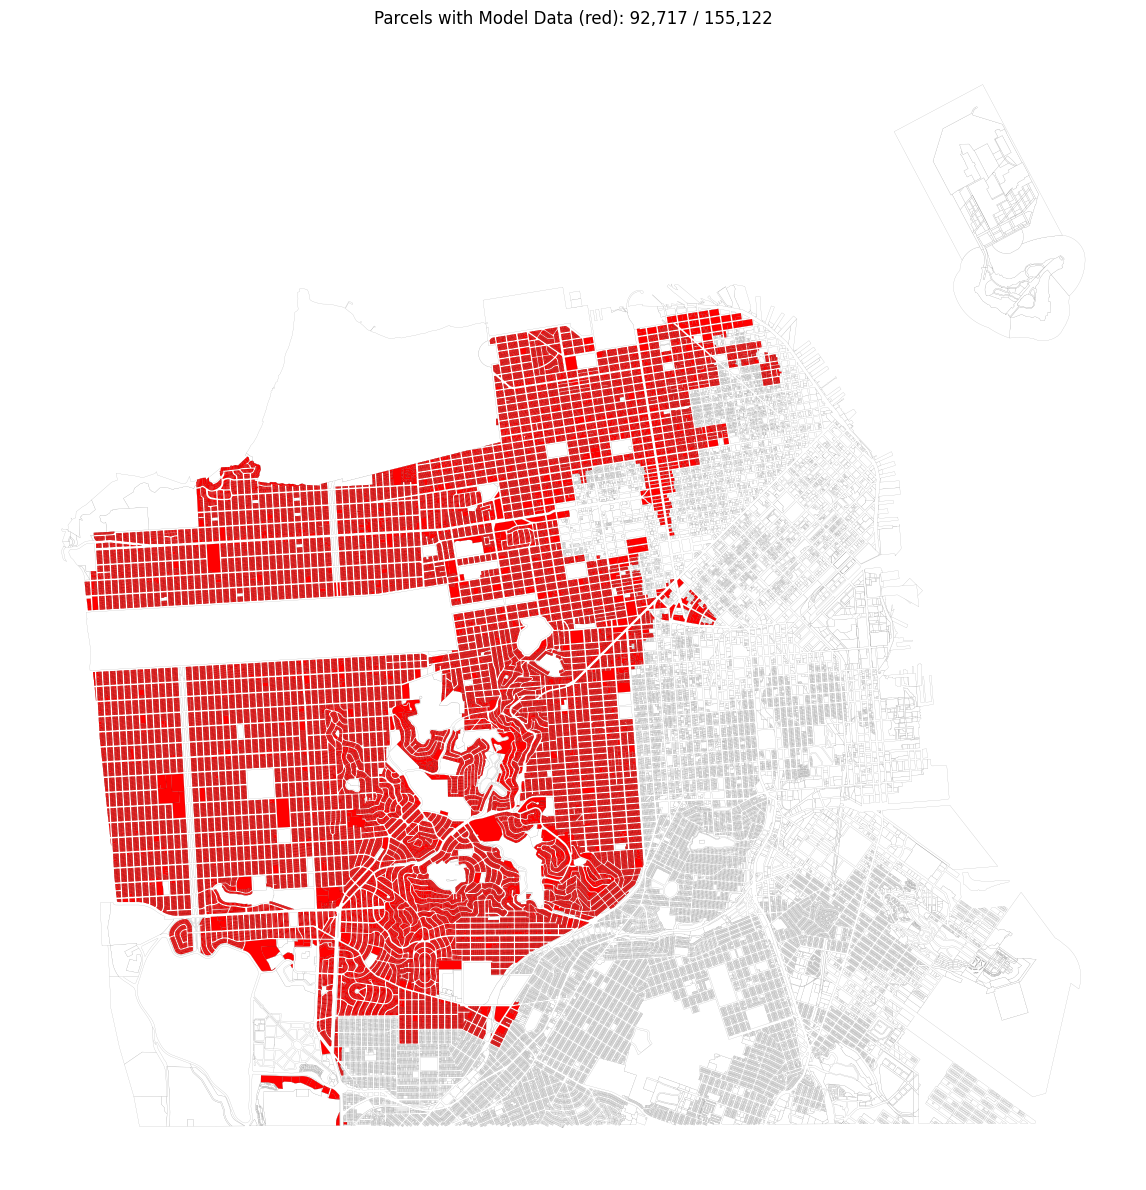

In [344]:
geom_df = parcels_df.copy()
geom_df['geometry'] = geom_df['shape'].apply(wkt.loads)
geom_df = gpd.GeoDataFrame(geom_df, geometry='geometry', crs='EPSG:4326')

model_mapblklots = set(model_by_mapblklot['mapblklot'])
geom_df['has_model'] = geom_df['mapblklot'].isin(model_mapblklots)

fig, ax = plt.subplots(figsize=(12, 12))
geom_df[~geom_df['has_model']].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.1)
geom_df[geom_df['has_model']].plot(ax=ax, color='red', edgecolor='darkred', linewidth=0.1)
ax.set_title(f'Parcels with Model Data (red): {geom_df["has_model"].sum():,} / {len(geom_df):,}')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Inspect Public Parcels

Green = public parcel (will be removed), White = non-public

NOTE: The list of public parcels was arbitrarily determined by me previously. I think it was based on some judgment and using the P zoning designation. TODO I could do it more systematically and document it here. 

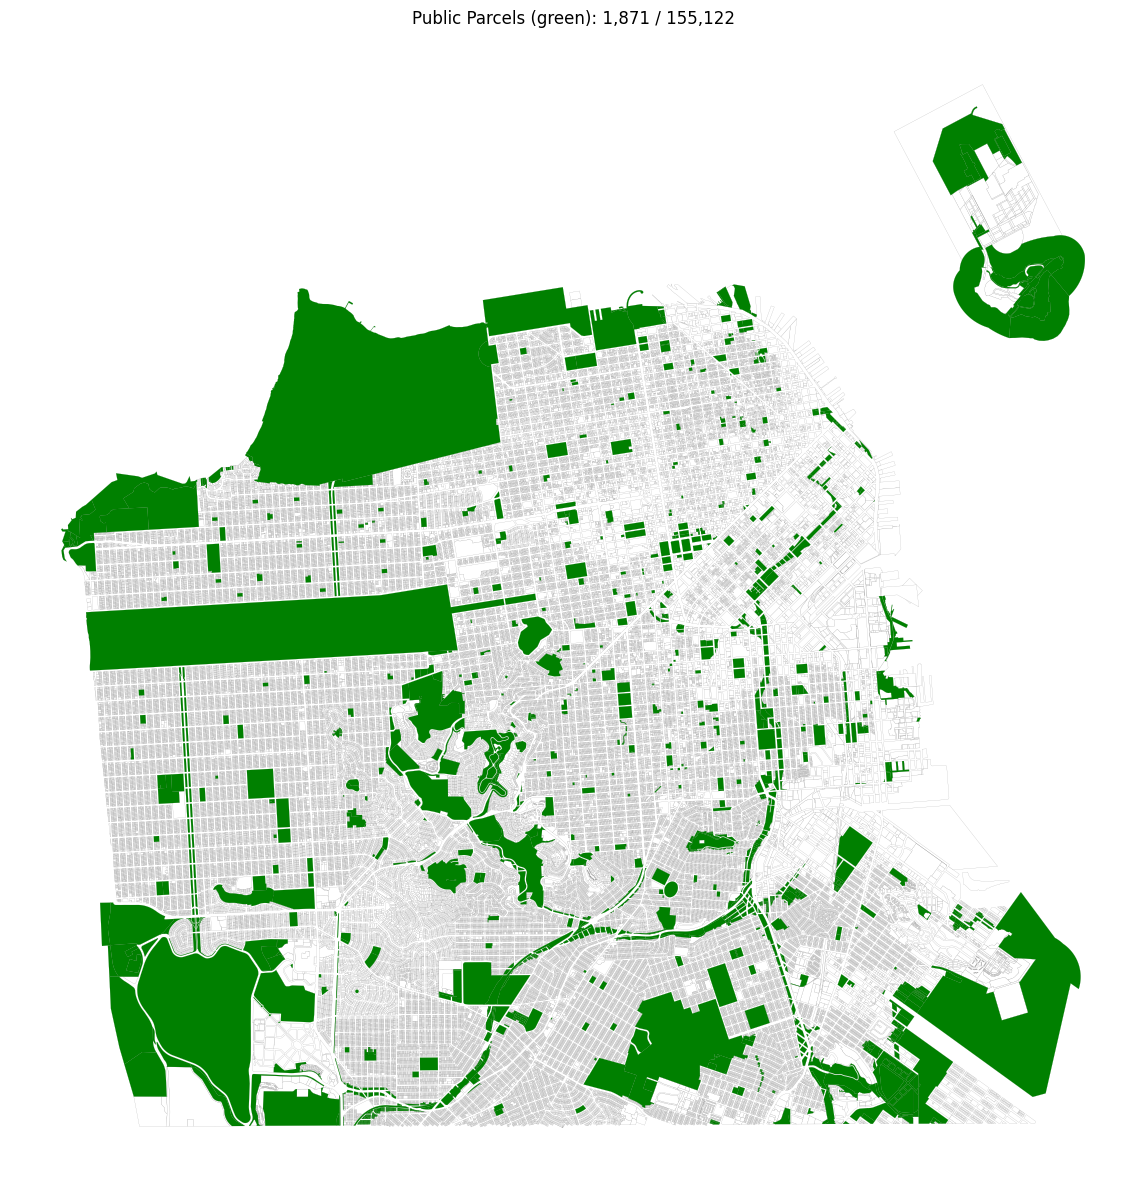

In [345]:
public_mapblklots = set(raw_public_parcels_df['mapblklot'])

geom_df['is_public'] = geom_df['mapblklot'].isin(public_mapblklots)

fig, ax = plt.subplots(figsize=(12, 12))
geom_df[~geom_df['is_public']].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.1)
geom_df[geom_df['is_public']].plot(ax=ax, color='green', edgecolor='darkgreen', linewidth=0.1)
ax.set_title(f'Public Parcels (green): {geom_df["is_public"].sum():,} / {len(geom_df):,}')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Remove Public Parcels

Remove parcels that are in public-parcels.geojson (parks, government buildings, etc.)

In [346]:
public_mapblklots = set(raw_public_parcels_df['mapblklot'])

before_count = len(parcels_df)
parcels_df = parcels_df[~parcels_df['mapblklot'].isin(public_mapblklots)]

print(f'Removed {before_count - len(parcels_df):,} public parcels')
print(f'Remaining: {len(parcels_df):,} parcels')

Removed 1,871 public parcels
Remaining: 153,251 parcels


### Double Check: Public parcels removed from main parcels

Red = has model data, White = no model data (after removing public parcels)

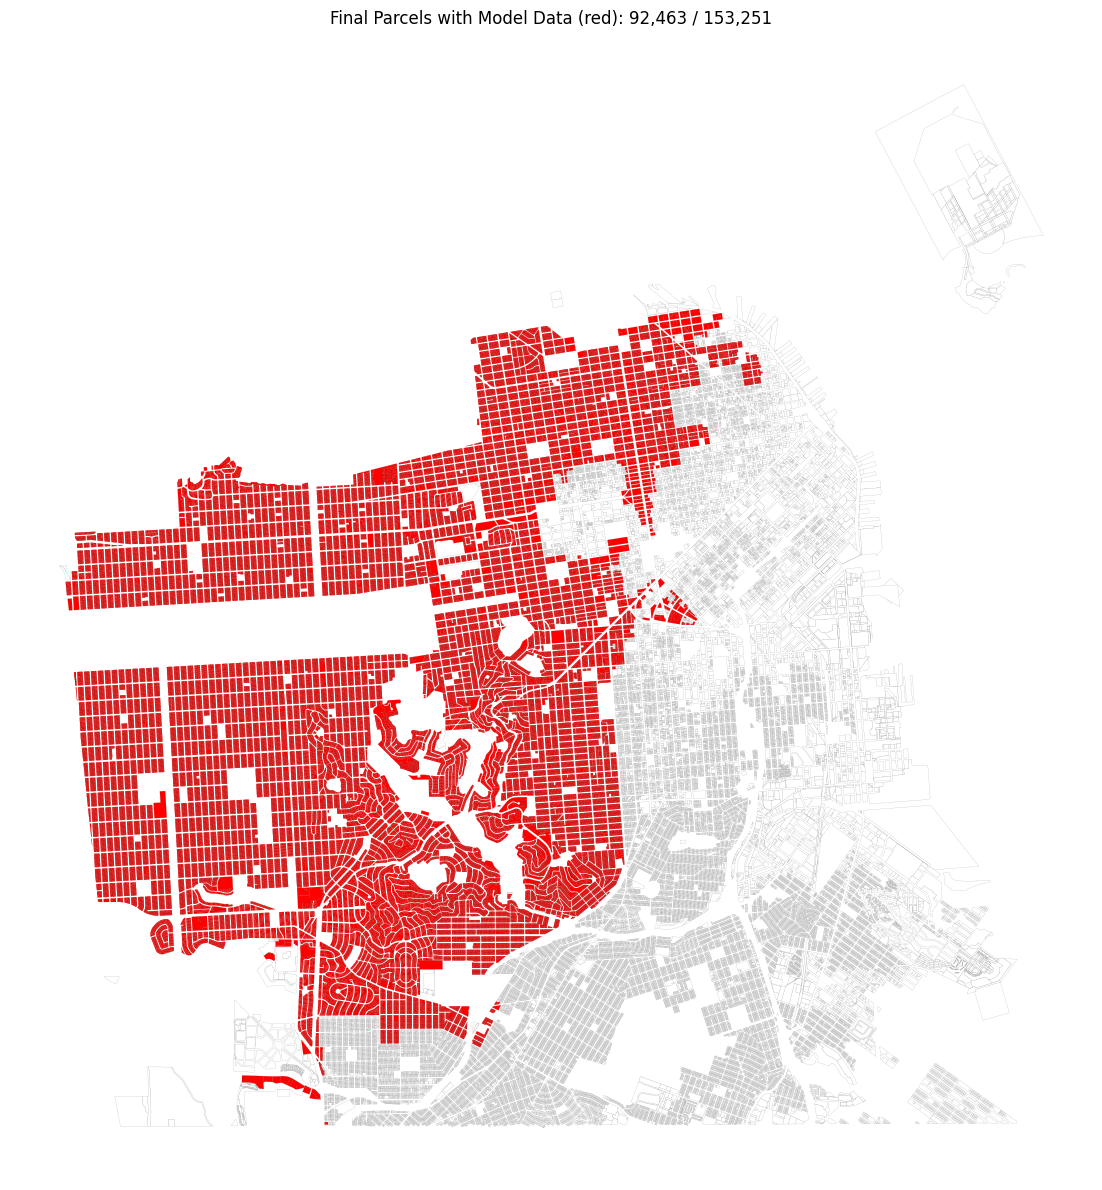

In [347]:
geom_df = parcels_df.copy()
geom_df['geometry'] = geom_df['shape'].apply(wkt.loads)
geom_df = gpd.GeoDataFrame(geom_df, geometry='geometry', crs='EPSG:4326')

geom_df['has_model'] = geom_df['mapblklot'].isin(model_mapblklots)

fig, ax = plt.subplots(figsize=(12, 12))
geom_df[~geom_df['has_model']].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.1)
geom_df[geom_df['has_model']].plot(ax=ax, color='red', edgecolor='darkred', linewidth=0.1)
ax.set_title(f'Final Parcels with Model Data (red): {geom_df["has_model"].sum():,} / {len(geom_df):,}')
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Calculate Area from Shape Geometry

Compare calculated area from WKT geometry against the existing Shape_Area_SqFt from model data to verify that the method I have in mind is correct/good.

In [348]:
test_area_df = parcels_df[parcels_df['Shape_Area_SqFt'].notna()].copy()
print(f'Parcels with existing Shape_Area_SqFt: {len(test_area_df):,}')

test_area_df['geometry'] = test_area_df['shape'].apply(wkt.loads)
test_area_gdf = gpd.GeoDataFrame(test_area_df, geometry='geometry', crs='EPSG:4326')

test_area_gdf = test_area_gdf.to_crs('EPSG:2227')
test_area_gdf['calculated_area_sqft'] = test_area_gdf.geometry.area

test_area_gdf['existing_area'] = test_area_gdf['Shape_Area_SqFt'].str.replace(',', '').astype(float)
test_area_gdf['area_diff'] = test_area_gdf['calculated_area_sqft'] - test_area_gdf['existing_area']
test_area_gdf['area_pct_diff'] = (test_area_gdf['area_diff'] / test_area_gdf['existing_area']) * 100

print(f'\nArea comparison statistics:')
print(f'Mean absolute difference: {test_area_gdf["area_diff"].abs().mean():,.1f} sqft')
print(f'Median absolute difference: {test_area_gdf["area_diff"].abs().median():,.1f} sqft')
print(f'Mean percentage difference: {test_area_gdf["area_pct_diff"].mean():.2f}%')
print(f'Median percentage difference: {test_area_gdf["area_pct_diff"].median():.2f}%')
print(f'\nPercentile distribution of absolute percentage difference:')
for p in [50, 90, 95, 99]:
    print(f'  {p}th percentile: {np.percentile(test_area_gdf["area_pct_diff"].abs(), p):.2f}%')

Parcels with existing Shape_Area_SqFt: 92,463

Area comparison statistics:
Mean absolute difference: 5.4 sqft
Median absolute difference: 0.2 sqft
Mean percentage difference: inf%
Median percentage difference: 0.00%

Percentile distribution of absolute percentage difference:
  50th percentile: 0.01%
  90th percentile: 0.02%
  95th percentile: 0.02%
  99th percentile: 0.03%


### Calculate Area for Parcels Missing Shape_Area_SqFt
Looks good! For parcels without model data, calculate area from the WKT geometry using EPSG:2227 (California State Plane Zone 3, feet).

In [349]:
missing_area_mask = parcels_df['Shape_Area_SqFt'].isna()
print(f'Parcels missing Shape_Area_SqFt: {missing_area_mask.sum():,}')
print(f'Parcels with Shape_Area_SqFt: {(~missing_area_mask).sum():,}')

missing_gdf = gpd.GeoDataFrame(
    parcels_df[missing_area_mask],
    geometry=parcels_df.loc[missing_area_mask, 'shape'].apply(wkt.loads),
    crs='EPSG:4326'
).to_crs('EPSG:2227')

area_lookup = missing_gdf.geometry.area.to_dict()
parcels_df.loc[missing_area_mask, 'Shape_Area_SqFt'] = parcels_df.loc[missing_area_mask].index.map(area_lookup).astype(str)

print(f'\nAfter filling:')
print(f'Parcels with Shape_Area_SqFt: {parcels_df["Shape_Area_SqFt"].notna().sum():,}')
print(f'Parcels without Shape_Area_SqFt: {parcels_df["Shape_Area_SqFt"].isna().sum():,}')

parcels_df['Shape_Area_SqFt_numeric'] = parcels_df['Shape_Area_SqFt'].str.replace(',', '').astype(float)
parcels_df.loc[missing_area_1000_mask, 'Area_1000'] = (parcels_df.loc[missing_area_1000_mask, 'Shape_Area_SqFt_numeric'] / 1000).astype(str)
parcels_df = parcels_df.drop(columns=['Shape_Area_SqFt_numeric'])

print(f'Parcels with Area_1000: {parcels_df["Area_1000"].notna().sum():,}')
print(f'Parcels without Area_1000: {parcels_df["Area_1000"].isna().sum():,}')

Parcels missing Shape_Area_SqFt: 60,788
Parcels with Shape_Area_SqFt: 92,463

After filling:
Parcels with Shape_Area_SqFt: 153,251
Parcels without Shape_Area_SqFt: 0
Parcels with Area_1000: 153,251
Parcels without Area_1000: 0


## Set up DIST_* variable

### Planning District Distribution

Count of parcels by planning district.

In [350]:
district_counts = parcels_df['planning_district'].value_counts(dropna=False).sort_index()
print(f'Planning district distribution ({len(parcels_df):,} parcels):\n')
for district, count in district_counts.items():
    label = district if pd.notna(district) else '(null)'
    print(f'  {label}: {count:,}')

Planning district distribution (153,251 parcels):

  Bernal Heights: 6,631
  Buena Vista: 5,114
  Central: 12,450
  Downtown: 2,269
  Ingleside: 16,534
  Inner Sunset: 12,001
  Marina: 6,391
  Mission: 7,194
  Northeast: 6,275
  Outer Sunset: 20,795
  Presidio: 16
  Richmond: 17,031
  South Bayshore: 9,381
  South Central: 21,146
  South of Market: 5,014
  Western Addition: 5,009


### Remove Presidio Parcels

Remove parcels in the Presidio planning district (federal land, not subject to SF zoning).

In [351]:
before_count = len(parcels_df)
parcels_df = parcels_df[parcels_df['planning_district'] != 'Presidio']

print(f'Removed {before_count - len(parcels_df):,} Presidio parcels')
print(f'Remaining: {len(parcels_df):,} parcels')

Removed 16 Presidio parcels
Remaining: 153,235 parcels


### Compare DIST_* Columns to Planning District

Verify that the mapping from `planning_district` to DIST_* columns matches the existing model data.

In [352]:
planning_to_dist = {
    'South Bayshore': 'DIST_SBayshore',
    'Bernal Heights': 'DIST_BernalHts',
    'South Central': 'DIST_Scentral',
    'Central': 'DIST_Central',
    'Buena Vista': 'DIST_BuenaVista',
    'Northeast': 'DIST_Northeast',
    'Western Addition': 'DIST_WestAddition',
    'South of Market': 'DIST_SOMA',
    'Inner Sunset': 'DIST_InnerSunset',
    'Richmond': 'DIST_Richmond',
    'Ingleside': 'DIST_Ingleside',
    'Outer Sunset': 'DIST_OuterSunset',
    'Marina': 'DIST_Marina',
    'Mission': 'DIST_Mission',
}

dist_cols = [c for c in parcels_df.columns if c.startswith('DIST_')]
has_model = parcels_df[dist_cols[0]].notna()
model_parcels = parcels_df[has_model]

print(f'Parcels with existing DIST_* data: {len(model_parcels):,}')

total_discrepancies = 0
discrepancies_by_col = {}

for district, col in planning_to_dist.items():
    expected = (model_parcels['planning_district'] == district).astype(int)
    actual = model_parcels[col].astype(int)
    diff = (expected != actual).sum()
    if diff > 0:
        discrepancies_by_col[col] = diff
        total_discrepancies += diff

print(f'Total discrepancies: {total_discrepancies:,}')
if discrepancies_by_col:
    print(f'\nDiscrepancies by column:')
    for col, count in sorted(discrepancies_by_col.items(), key=lambda x: -x[1]):
        print(f'  {col}: {count:,}')
else:
    print('Mapping is correct!')

Parcels with existing DIST_* data: 92,447
Total discrepancies: 0
Mapping is correct!


### Fill DIST_* Columns for Parcels Missing Model Data

For parcels without model data, set DIST_* columns based on planning_district.

In [353]:
missing_dist_mask = parcels_df[dist_cols[0]].isna()
print(f'Parcels missing DIST_* data: {missing_dist_mask.sum():,}')

for col in dist_cols:
    parcels_df.loc[missing_dist_mask, col] = '0'

for district, col in planning_to_dist.items():
    mask = missing_dist_mask & (parcels_df['planning_district'] == district)
    parcels_df.loc[mask, col] = '1'

print(f'\nAfter filling:')
print(f'Parcels with DIST_* data: {parcels_df[dist_cols[0]].notna().sum():,}')
print(f'Parcels without DIST_* data: {parcels_df[dist_cols[0]].isna().sum():,}')

Parcels missing DIST_* data: 60,788

After filling:
Parcels with DIST_* data: 153,235
Parcels without DIST_* data: 0


### Sanity Check: Any row with all 0s should be in the "Downtown" planning neighborhood

In [354]:
all_dist_zero = (parcels_df[dist_cols].astype(int).sum(axis=1) == 0)
print(f'Parcels with all DIST_* = 0: {all_dist_zero.sum():,}')

non_downtown = all_dist_zero & (parcels_df['planning_district'] != 'Downtown')
print(f'Parcels with all DIST_* = 0 but NOT Downtown: {non_downtown.sum():,}')

if non_downtown.sum() > 0:
    print(f'\nUnexpected planning districts:')
    print(parcels_df.loc[non_downtown, 'planning_district'].value_counts())
else:
    print('Check passed!')

Parcels with all DIST_* = 0: 2,269
Parcels with all DIST_* = 0 but NOT Downtown: 0
Check passed!


## Merge Land Use Data - Res_Dummy

test the hypothesis: Res_Dummy = 1 if ResUnits > 0

In [355]:
land_use_mapblklots = set(raw_land_use_df['mapblklot'])
model_mapblklots = set(raw_model_df['BlockLot'].map(blklot_to_mapblklot).dropna())

print(f'\nLand use mapblklots: {len(land_use_mapblklots):,}')
print(f'Model mapblklots: {len(model_mapblklots):,}')
print(f'Overlap: {len(land_use_mapblklots & model_mapblklots):,}')


Land use mapblklots: 154,476
Model mapblklots: 92,717
Overlap: 92,715


In [356]:
test_df = parcels_df[parcels_df['Res_Dummy'].notna()][['mapblklot', 'Res_Dummy']].copy()
print(f'Parcels with Res_Dummy in model data: {len(test_df):,}')

land_use_subset = raw_land_use_df[['mapblklot', 'resunits']].copy()
land_use_subset['resunits_numeric'] = land_use_subset['resunits'].str.replace(',', '').astype(float)

test_df = test_df.merge(land_use_subset, on='mapblklot', how='inner')
print(f'Matched with land-use data: {len(test_df):,}')

test_df['Res_Dummy_int'] = test_df['Res_Dummy'].astype(int)
test_df['predicted_res_dummy'] = (test_df['resunits_numeric'] > 0).astype(int)

match = (test_df['Res_Dummy_int'] == test_df['predicted_res_dummy']).sum()
mismatch = len(test_df) - match

print(f'\nHypothesis: Res_Dummy = 1 if resunits > 0')
print(f'Match: {match:,} ({match/len(test_df)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(test_df)*100:.1f}%)')

if mismatch > 0:
    print(f'\nMismatch breakdown:')
    mismatch_df = test_df[test_df['Res_Dummy_int'] != test_df['predicted_res_dummy']]
    print(f'  Res_Dummy=1 but resunits=0: {((mismatch_df["Res_Dummy_int"] == 1) & (mismatch_df["resunits_numeric"] == 0)).sum():,}')
    print(f'  Res_Dummy=0 but resunits>0: {((mismatch_df["Res_Dummy_int"] == 0) & (mismatch_df["resunits_numeric"] > 0)).sum():,}')

Parcels with Res_Dummy in model data: 92,447
Matched with land-use data: 92,445

Hypothesis: Res_Dummy = 1 if resunits > 0
Match: 92,432 (100.0%)
Mismatch: 13 (0.0%)

Mismatch breakdown:
  Res_Dummy=1 but resunits=0: 0
  Res_Dummy=0 but resunits>0: 13


### Fill Res_Dummy and ResUnits for Parcels Missing Model Data

13 is not 0 but seems good enough so let's move forward with it.

In [357]:
missing_res_dummy_mask = parcels_df['Res_Dummy'].isna()
print(f'Parcels missing Res_Dummy: {missing_res_dummy_mask.sum():,}')
print(f'Parcels with Res_Dummy: {(~missing_res_dummy_mask).sum():,}')

land_use_lookup = raw_land_use_df.set_index('mapblklot')['resunits'].to_dict()

parcels_df.loc[missing_res_dummy_mask, 'Res_Units'] = parcels_df.loc[missing_res_dummy_mask, 'mapblklot'].map(land_use_lookup)

res_units_numeric = parcels_df.loc[missing_res_dummy_mask, 'Res_Units'].str.replace(',', '').astype(float)
parcels_df.loc[missing_res_dummy_mask, 'Res_Dummy'] = (res_units_numeric > 0).astype(int).astype(str)

print(f'\nAfter filling:')
print(f'Parcels with Res_Dummy: {parcels_df["Res_Dummy"].notna().sum():,}')
print(f'Parcels without Res_Dummy: {parcels_df["Res_Dummy"].isna().sum():,}')
print(f'Parcels with Res_Units: {parcels_df["Res_Units"].notna().sum():,}')
print(f'Parcels without Res_Units: {parcels_df["Res_Units"].isna().sum():,}')

Parcels missing Res_Dummy: 60,788
Parcels with Res_Dummy: 92,447

After filling:
Parcels with Res_Dummy: 153,235
Parcels without Res_Dummy: 0
Parcels with Res_Units: 152,515
Parcels without Res_Units: 720


### TODO: Investigate the 720 missing Res_Units
Hypothesis 1: Mapblklots vs. blocklots. Try it using blocklots.

## Get existing building size

In [358]:
sqft_cols = ['visitor', 'pdr', 'retail', 'mips', 'med', 'cie', 'res']

land_use_sqft = raw_land_use_df[['mapblklot'] + sqft_cols].copy()
for col in sqft_cols:
    land_use_sqft[col] = land_use_sqft[col].str.replace(',', '').astype(float)

land_use_sqft['calculated_sqft'] = land_use_sqft[sqft_cols].sum(axis=1)

test_df = parcels_df[parcels_df['Tot_Existing_SqFt'].notna()][['mapblklot', 'Tot_Existing_SqFt']].copy()
test_df['existing_sqft'] = test_df['Tot_Existing_SqFt'].str.replace(',', '').astype(float)
test_df = test_df.merge(land_use_sqft[['mapblklot', 'calculated_sqft']], on='mapblklot', how='inner')

print(f'Parcels with existing Tot_Existing_SqFt: {len(test_df):,}')

test_df['diff'] = test_df['calculated_sqft'] - test_df['existing_sqft']
match = (test_df['diff'].abs() < 1).sum()
mismatch = len(test_df) - match

print(f'\nCalculated vs Tot_Existing_SqFt:')
print(f'Match: {match:,} ({match/len(test_df)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(test_df)*100:.1f}%)')

if mismatch > 0:
    print(f'\nMismatch statistics:')
    print(f'Mean diff: {test_df["diff"].mean():,.1f}')
    print(f'Median diff: {test_df["diff"].median():,.1f}')
    print(f'\nSample mismatches:')
    mismatch_df = test_df[test_df['diff'].abs() >= 1].sort_values('diff', key=abs, ascending=False)
    print(mismatch_df[['mapblklot', 'existing_sqft', 'calculated_sqft', 'diff']].head(10).to_string())

Parcels with existing Tot_Existing_SqFt: 92,442

Calculated vs Tot_Existing_SqFt:
Match: 64,685 (70.0%)
Mismatch: 27,757 (30.0%)

Mismatch statistics:
Mean diff: 269.5
Median diff: 0.0

Sample mismatches:
      mapblklot  existing_sqft  calculated_sqft      diff
68509   0695007      1015000.0          38805.0 -976195.0
78472   0671009       216909.0         913457.0  696548.0
39523   0628014       662281.0          94205.0 -568076.0
78670   3583011         3600.0         565784.0  562184.0
35191   0628013       127189.0         660227.0  533038.0
297     1049070         1596.0         452285.0  450689.0
1037    0451007       128000.0         521083.0  393083.0
35241   0606002         6690.0         385440.0  378750.0
57      0690017       200000.0         519223.0  319223.0
78731   1098050       384808.0          96067.0 -288741.0


In [359]:
sqft_cols = ['visitor', 'pdr', 'retail', 'mips', 'med', 'cie', 'res']

land_use_sqft = raw_land_use_df[['mapblklot'] + sqft_cols].copy()
for col in sqft_cols:
    land_use_sqft[col] = land_use_sqft[col].str.replace(',', '').astype(float)

test_df = parcels_df[parcels_df['Tot_Existing_SqFt'].notna()][['mapblklot', 'Tot_Existing_SqFt']].copy()
test_df['existing_sqft'] = test_df['Tot_Existing_SqFt'].str.replace(',', '').astype(float)
test_df = test_df.merge(land_use_sqft, on='mapblklot', how='inner')

test_df['calc_all'] = test_df[sqft_cols].sum(axis=1)
test_df['calc_res_only'] = test_df['res']
test_df['calc_res_retail_cie'] = test_df['res'] + test_df['retail'] + test_df['cie']

test_df['match_all'] = (test_df['calc_all'] - test_df['existing_sqft']).abs() < 1
test_df['match_res_only'] = (test_df['calc_res_only'] - test_df['existing_sqft']).abs() < 1
test_df['match_res_retail_cie'] = (test_df['calc_res_retail_cie'] - test_df['existing_sqft']).abs() < 1

print(f'Total parcels: {len(test_df):,}\n')
print(f'Match rates by formula:')
print(f'  All cols (visitor+pdr+retail+mips+med+cie+res): {test_df["match_all"].sum():,} ({test_df["match_all"].mean()*100:.1f}%)')
print(f'  res only: {test_df["match_res_only"].sum():,} ({test_df["match_res_only"].mean()*100:.1f}%)')
print(f'  res + retail + cie: {test_df["match_res_retail_cie"].sum():,} ({test_df["match_res_retail_cie"].mean()*100:.1f}%)')

mismatch_all = test_df[~test_df['match_all']]
match_all = test_df[test_df['match_all']]

print(f'\n--- Mismatch analysis (all cols formula) ---')
print(f'Mismatches: {len(mismatch_all):,}')

print(f'\nColumn value distributions (mean):')
print(f'{"Column":<12} {"Match":>12} {"Mismatch":>12}')
print('-' * 38)
for col in sqft_cols:
    print(f'{col:<12} {match_all[col].mean():>12,.1f} {mismatch_all[col].mean():>12,.1f}')

print(f'\nColumn non-zero rates:')
print(f'{"Column":<12} {"Match":>12} {"Mismatch":>12}')
print('-' * 38)
for col in sqft_cols:
    match_nz = (match_all[col] > 0).mean() * 100
    mismatch_nz = (mismatch_all[col] > 0).mean() * 100
    print(f'{col:<12} {match_nz:>11.1f}% {mismatch_nz:>11.1f}%')

print(f'\nFor mismatches, which single column matches existing_sqft?')
for col in sqft_cols:
    matches_col = ((mismatch_all[col] - mismatch_all['existing_sqft']).abs() < 1).sum()
    if matches_col > 0:
        print(f'  {col}: {matches_col:,}')

print(f'\nFor mismatches, which combo matches existing_sqft?')
combos = [
    ('res', ['res']),
    ('res+retail', ['res', 'retail']),
    ('res+cie', ['res', 'cie']),
    ('res+retail+cie', ['res', 'retail', 'cie']),
    ('res+retail+mips', ['res', 'retail', 'mips']),
]
for name, cols in combos:
    calc = mismatch_all[cols].sum(axis=1)
    matches = ((calc - mismatch_all['existing_sqft']).abs() < 1).sum()
    if matches > 0:
        print(f'  {name}: {matches:,}')

Total parcels: 92,442

Match rates by formula:
  All cols (visitor+pdr+retail+mips+med+cie+res): 64,685 (70.0%)
  res only: 77,981 (84.4%)
  res + retail + cie: 73,895 (79.9%)

--- Mismatch analysis (all cols formula) ---
Mismatches: 27,757

Column value distributions (mean):
Column              Match     Mismatch
--------------------------------------
visitor               0.8         45.3
pdr                   1.7        265.9
retail                0.7        751.0
mips                  0.9      1,400.5
med                   0.1        422.9
cie                   4.4        447.8
res               2,360.8      2,777.7

Column non-zero rates:
Column              Match     Mismatch
--------------------------------------
visitor              0.0%         0.5%
pdr                  0.0%         8.5%
retail               0.0%        16.3%
mips                 0.0%        36.7%
med                  0.0%         5.4%
cie                  0.0%         7.3%
res                 98.5%        76.

## Apply residential square feet to building size.
It appears that the best way to approximate what Egan did for this attribute is to simply take residential square footage. However, as demonstratd above, while it covers about 85% of all parcels, the remaining 15% do not match this. 

If you dig deeper, it is unclear where/how Egan is getting his numbers. A bunch of his parcels have 0 current building sq ft, even though the land use database says it does. Elsewhere the land use database says there is no square footage but Egan's data says it does. 

Very likely I am not looking at the correct data source. TODO: Figure out where Egan is getting this data. 

For now, though, this is good enough to continue on.

In [360]:
missing_sqft_mask = parcels_df['Tot_Existing_SqFt'].isna()
print(f'Parcels missing Tot_Existing_SqFt: {missing_sqft_mask.sum():,}')

res_lookup = raw_land_use_df.set_index('mapblklot')['res'].to_dict()

parcels_df.loc[missing_sqft_mask, 'Tot_Existing_SqFt'] = parcels_df.loc[missing_sqft_mask, 'mapblklot'].map(res_lookup)
parcels_df.loc[missing_sqft_mask, 'Tot_Existing_SqFt'] = parcels_df.loc[missing_sqft_mask, 'Tot_Existing_SqFt'].str.replace(',', '').astype(float)
parcels_df.loc[missing_sqft_mask, 'Bldg_SqFt_1000'] = parcels_df.loc[missing_sqft_mask, 'Tot_Existing_SqFt'] / 1000

print(f'\nAfter filling:')
print(f'Parcels with tot_existing_sqft: {parcels_df["Tot_Existing_SqFt"].notna().sum():,}')
print(f'Parcels without tot_existing_sqft: {parcels_df["Tot_Existing_SqFt"].isna().sum():,}')
print(f'Parcels with Bldg_SqFt_1000: {parcels_df["Bldg_SqFt_1000"].notna().sum():,}')
print(f'Parcels without Bldg_SqFt_1000: {parcels_df["Bldg_SqFt_1000"].isna().sum():,}')

Parcels missing Tot_Existing_SqFt: 60,791

After filling:
Parcels with tot_existing_sqft: 152,518
Parcels without tot_existing_sqft: 717
Parcels with Bldg_SqFt_1000: 152,518
Parcels without Bldg_SqFt_1000: 717


## Apply the right zoning code to each parcel missing the zoning code.
The FZP Planning Code attribute will determine which ZP_* attribute gets passed to the mode.

### Hypothesis 1: Use zoning_code from land-use.csv for Planning Code.

If we took the zoning_code attribute from land-use.csv and dumb applied it to FZP Planning code, this is the number of FZP Planning Codes that would have been correct (matched) vs. incorrect (mismatched).

In [361]:
model_parcels = parcels_df[parcels_df['FZP Planning Code'].notna()].copy()
print(f'Parcels with FZP Planning Code: {len(model_parcels):,}')

match = (model_parcels['zoning_code'] == model_parcels['FZP Planning Code']).sum()
mismatch = len(model_parcels) - match

print(f'\nzoning_code vs FZP Planning Code:')
print(f'Match: {match:,} ({match/len(model_parcels)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(model_parcels)*100:.1f}%)')

Parcels with FZP Planning Code: 92,447

zoning_code vs FZP Planning Code:
Match: 78,569 (85.0%)
Mismatch: 13,878 (15.0%)


In [362]:
mismatch_df = model_parcels[model_parcels['zoning_code'] != model_parcels['FZP Planning Code']].copy()
mismatch_df['pair'] = mismatch_df['zoning_code'] + ' -> ' + mismatch_df['FZP Planning Code']
pair_counts = mismatch_df['pair'].value_counts()

print(f'Mismatched pairs ({len(mismatch_df):,} total):\n')
print(pair_counts.to_string())

Mismatched pairs (13,878 total):

pair
RH-2 -> RTO-C                                3246
RH-1 -> RTO-C                                1626
RH-3 -> RTO-C                                1402
RTO -> RTO-1                                 1302
RM-1 -> RTO-C                                1291
RH-1(D) -> RTO-C                              541
NCD -> NCD-GEARY BOULEVARD                    389
RM-2 -> RTO-C                                 305
NCD -> NCD-POLK                               247
NCD -> NCD-INNER SUNSET                       244
NCD -> NCD-TARAVAL                            243
NCD -> NCD-UNION                              215
RM-3 -> RTO-C                                 207
NCT -> NCT-DIVISADERO                         179
NCD -> NCD-24TH-NOE-VALLEY                    162
NCD -> NCD-INNER CLEMENT                      161
NCT -> NCT-UPPER MARKET                       132
NCD -> NCD-OUTER CLEMENT                      118
NCT -> NCT-OCEAN                              115
NCD -> NCD-

### Hypothesis 2 - zoning districts csv

Let's use a separate dataset called zoning districts.

In [363]:
model_parcels = parcels_df[parcels_df['FZP Planning Code'].notna()].copy()
print(f'Parcels with FZP Planning Code: {len(model_parcels):,}')

model_parcels['geometry'] = model_parcels['shape'].apply(wkt.loads)
model_gdf = gpd.GeoDataFrame(model_parcels, geometry='geometry', crs='EPSG:4326')

model_gdf_projected = model_gdf.to_crs('EPSG:2227')
model_gdf['centroid'] = model_gdf_projected.geometry.centroid.to_crs('EPSG:4326')

centroid_gdf = model_gdf.set_geometry('centroid')
joined = gpd.sjoin(centroid_gdf, raw_zoning_district_gdf[['geometry', 'zoning']], how='left', predicate='within')
joined = joined.rename(columns={'zoning': 'zoning_district_code'})

model_gdf['zoning_district_code'] = joined['zoning_district_code'].values

match = (model_gdf['zoning_district_code'] == model_gdf['FZP Planning Code']).sum()
no_zone_found = model_gdf['zoning_district_code'].isna().sum()
mismatch = len(model_gdf) - match - no_zone_found

print(f'\nzoning-district.csv vs FZP Planning Code:')
print(f'Match: {match:,} ({match/len(model_gdf)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(model_gdf)*100:.1f}%)')
print(f'No zone found (centroid outside all districts): {no_zone_found:,} ({no_zone_found/len(model_gdf)*100:.1f}%)')

Parcels with FZP Planning Code: 92,447

zoning-district.csv vs FZP Planning Code:
Match: 82,079 (88.8%)
Mismatch: 10,368 (11.2%)
No zone found (centroid outside all districts): 0 (0.0%)


In [364]:
mismatch_mask = (model_gdf['zoning_district_code'] != model_gdf['FZP Planning Code']) & model_gdf['zoning_district_code'].notna()
mismatch_gdf = model_gdf[mismatch_mask].copy()
mismatch_gdf['pair'] = mismatch_gdf['zoning_district_code'] + ' -> ' + mismatch_gdf['FZP Planning Code']
pair_counts = mismatch_gdf['pair'].value_counts()

print(f'Mismatched pairs ({len(mismatch_gdf):,} total):\n')
print(pair_counts.head(50).to_string())

Mismatched pairs (10,368 total):

pair
RH-2 -> RTO-C                       3247
RH-1 -> RTO-C                       1626
RH-3 -> RTO-C                       1403
RTO -> RTO-1                        1307
RM-1 -> RTO-C                       1295
RH-1(D) -> RTO-C                     542
RM-2 -> RTO-C                        310
RM-3 -> RTO-C                        210
RC-4 -> RTO-C                         50
RTO -> RTO-C                          41
RH-2 -> NC-1                          25
RH-2 -> NCD-GEARY BOULEVARD           21
RH-2 -> NCD-INNER SUNSET              19
RH-1 -> NC-1                          17
RH-1 -> NCD-NORIEGA                   15
RM-1 -> NCD-OUTER CLEMENT             11
RM-4 -> RTO-C                         11
RM-1 -> NCD-INNER CLEMENT             11
RM-1 -> NC-S                          10
RM-1 -> NCD-GEARY BOULEVARD            9
NCD-UPPER FILLMORE -> RTO-C            8
RH-2 -> NCD-OUTER CLEMENT              8
RH-2 -> NCT-GLEN PARK                  8
RH-2 -> NCD-OUTER 

### Apply Hypothesis 2
Approach #2 is slightly better. So let's go with that.
For parcels missing FZP Planning Code, use spatial join with zoning-district.csv to fill in the zoning code.

In [365]:
missing_zoning_mask = parcels_df['FZP Planning Code'].isna()
print(f'Parcels missing FZP Planning Code: {missing_zoning_mask.sum():,}')

missing_parcels = parcels_df[missing_zoning_mask].copy()
missing_parcels['geometry'] = missing_parcels['shape'].apply(wkt.loads)
missing_gdf = gpd.GeoDataFrame(missing_parcels, geometry='geometry', crs='EPSG:4326')

missing_gdf_projected = missing_gdf.to_crs('EPSG:2227')
missing_gdf['centroid'] = missing_gdf_projected.geometry.centroid.to_crs('EPSG:4326')

centroid_gdf = missing_gdf.set_geometry('centroid')
joined = gpd.sjoin(centroid_gdf, raw_zoning_district_gdf[['geometry', 'zoning']], how='left', predicate='within')

zoning_lookup = joined.set_index(joined.index)['zoning'].to_dict()
parcels_df.loc[missing_zoning_mask, 'FZP Planning Code'] = parcels_df.loc[missing_zoning_mask].index.map(zoning_lookup)

print(f'\nAfter filling:')
print(f'Parcels with FZP Planning Code: {parcels_df["FZP Planning Code"].notna().sum():,}')
print(f'Parcels without FZP Planning Code: {parcels_df["FZP Planning Code"].isna().sum():,}')

Parcels missing FZP Planning Code: 60,788

After filling:
Parcels with FZP Planning Code: 152,405
Parcels without FZP Planning Code: 830


### Map FZP Planning Code to zp_* Attributes

Based on pages 35-37 of the Egan report, map each parcel's `FZP Planning Code` to the appropriate `zp_*` dummy variable. RH-1/RH-1(D) is the baseline (all zp_* = 0). For parcels missing `FZP Planning Code`, leave all zp_* blank.

In [366]:
zp_mapping = {
    'zp_RH2': [
        'RH-2',
    ],
    'zp_RH3_RM1': [
        'RH-3', 'RM-1',
    ],
    'zp_OfficeComm': [
        'C-2', 'C-3-G', 'C-3-O', 'C-3-O(SD)', 'C-3-R', 'C-3-S', 'C-M', 'CMUO', 'MUO', 'WMUO',
    ],
    'zp_DRMulti_RTO': [
        'NC-1', 'NC-2', 'NC-3', 'NC-S', 'RC-3', 'RC-4', 'RM-2', 'RM-3', 'RM-4', 'RSD', 'SLR', 'SSO',
        'NCD', 'NCD-24TH-MISSION', 'NCD-24TH-NOE-VALLEY', 'NCD-BROADWAY', 'NCD-CASTRO', 'NCD-COLE VALLEY',
        'NCD-CORTLAND AVENUE', 'NCD-EXCELSIOR OUTER MISSION', 'NCD-FILLMORE', 'NCD-GEARY BOULEVARD',
        'NCD-HAIGHT', 'NCD-HAYES', 'NCD-INNER BALBOA STREET', 'NCD-INNER CLEMENT', 'NCD-INNER SUNSET',
        'NCD-INNER TARAVAL STREET', 'NCD-IRVING', 'NCD-JAPANTOWN', 'NCD-JUDAH', 'NCD-LAKESIDE VILLAGE',
        'NCD-LOWER HAIGHT STREET', 'NCD-LOWER POLK STREET', 'NCD-MISSION BERNAL', 'NCD-NORIEGA',
        'NCD-NORTH BEACH', 'NCD-OUTER BALBOA STREET', 'NCD-OUTER CLEMENT', 'NCD-PACIFIC', 'NCD-POLK',
        'NCD-SACRAMENTO', 'NCD-SAN BRUNO AVENUE', 'NCD-TARAVAL', 'NCD-UNION', 'NCD-UPPER FILLMORE',
        'NCD-UPPER MARKET', 'NCD-VALENCIA', 'NCD-WEST PORTAL', 'NCD-BAYVIEW',
    ],
    'zp_FBDMulti_RTO': [
        'NCT', 'NCT-1', 'NCT-2', 'NCT-3', 'NCT-DIVISADERO', 'NCT-FOLSOM', 'NCT-GLEN PARK', 'NCT-HAYES',
        'NCT-MISSION', 'NCT-OCEAN', 'NCT-SOMA', 'NCT-UPPER MARKET',
        'RTO', 'RTO-1', 'RTO-C', 'RTO-M',
        'DTR', 'MUR', 'MUG', 'RCD', 'RED', 'RED-MX', 'RH DTR', 'SB-DTR', 'SPD', 'TB DTR', 'UMU', 'WMUG',
        'PM-MU1', 'PM-MU2', 'PM-R', 'P70-MU', 'MR-MU',
    ],
    'zp_PDRInd': [
        'M-1', 'M-2', 'PDR-1', 'PDR-1-B', 'PDR-1-D', 'PDR-1-G', 'PDR-2', 'SALI', 'SLI',
    ],
    'zp_Public': [
        'P', 'PM-CF', 'PM-OS', 'MB-O', 'MB-OS',
    ],
    'zp_Redev': [
        'HP-RA', 'MB-RA', 'MISS BAY N RED', 'MISS BAY S RED', 'MISS BAY S PLN',
    ],
}

code_to_zp = {}
for zp_col, codes in zp_mapping.items():
    for code in codes:
        code_to_zp[code] = zp_col

zp_cols = ['zp_OfficeComm', 'zp_DRMulti_RTO', 'zp_FBDMulti_RTO', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2', 'zp_RH3_RM1']

missing_zp_mask = parcels_df['zp_RH2'].isna()
print(f'Parcels missing zp_* data: {missing_zp_mask.sum():,}')

for col in zp_cols:
    parcels_df.loc[missing_zp_mask, col] = '0'

def get_zp_col(planning_code):
    if pd.isna(planning_code):
        return None
    code = planning_code.split(';')[0].strip()
    return code_to_zp.get(code, None)

for idx in parcels_df[missing_zp_mask].index:
    planning_code = parcels_df.loc[idx, 'FZP Planning Code']
    zp_col = get_zp_col(planning_code)
    if zp_col:
        parcels_df.loc[idx, zp_col] = '1'

print(f'\nAfter filling zp_* columns:')
for col in zp_cols:
    ones = (parcels_df[col] == '1').sum()
    print(f'  {col}: {ones:,} parcels with value 1')

still_all_zero = missing_zp_mask & (parcels_df[zp_cols].astype(int).sum(axis=1) == 0)
print(f'\nParcels with all zp_* = 0 (RH-1 baseline or unmapped): {still_all_zero.sum():,}')

Parcels missing zp_* data: 60,788

After filling zp_* columns:
  zp_OfficeComm: 1,936 parcels with value 1
  zp_DRMulti_RTO: 3,837 parcels with value 1
  zp_FBDMulti_RTO: 96,672 parcels with value 1
  zp_PDRInd: 1,934 parcels with value 1
  zp_Public: 16 parcels with value 1
  zp_Redev: 328 parcels with value 1
  zp_RH2: 9,398 parcels with value 1
  zp_RH3_RM1: 4,052 parcels with value 1

Parcels with all zp_* = 0 (RH-1 baseline or unmapped): 35,062


### Sanity Check: Visualize Parcels by Zoning Category (zp_*)

Map showing each parcel color-coded by its zoning category. The zp_* columns are mutually exclusive one-hot encoded categories.

Parcels by zoning category:
  zp_FBDMulti_RTO: 96,672
  baseline: 35,062
  zp_RH2: 9,398
  zp_RH3_RM1: 4,052
  zp_DRMulti_RTO: 3,837
  zp_OfficeComm: 1,936
  zp_PDRInd: 1,934
  zp_Redev: 328
  zp_Public: 16


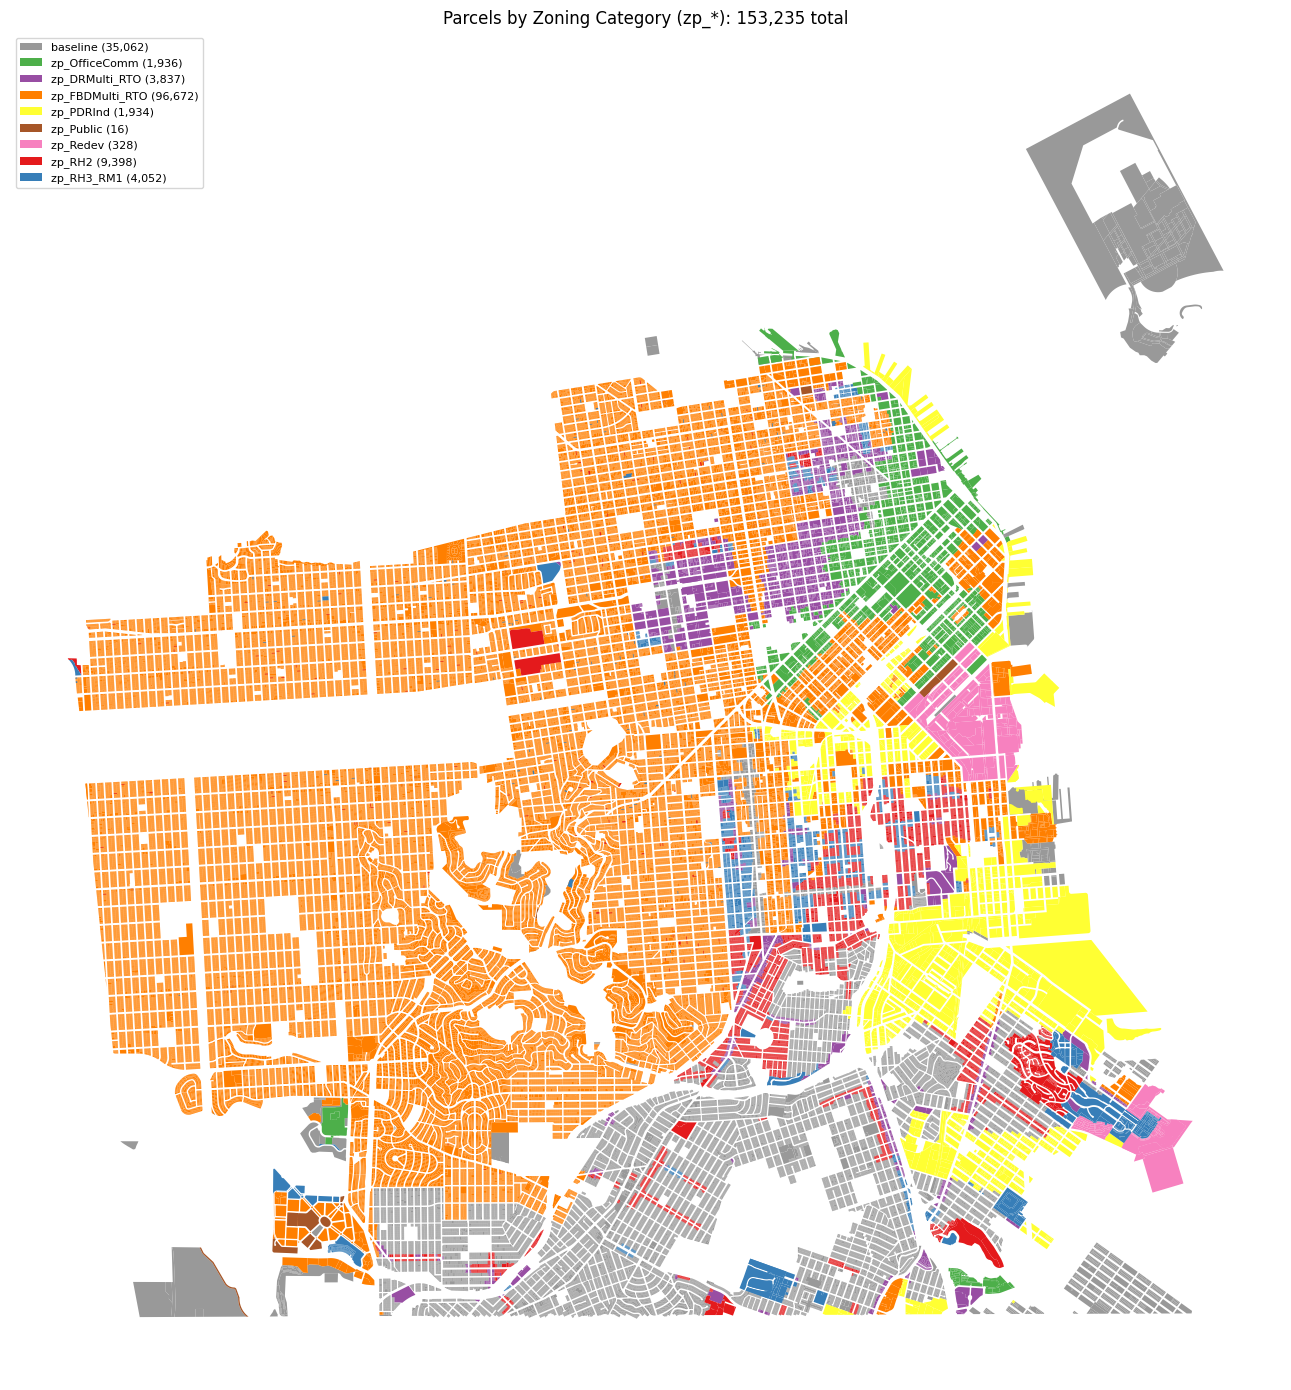

In [367]:
from matplotlib.patches import Patch

zp_colors = {
    'zp_RH2': '#e41a1c',
    'zp_RH3_RM1': '#377eb8',
    'zp_OfficeComm': '#4daf4a',
    'zp_DRMulti_RTO': '#984ea3',
    'zp_FBDMulti_RTO': '#ff7f00',
    'zp_PDRInd': '#ffff33',
    'zp_Public': '#a65628',
    'zp_Redev': '#f781bf',
    'baseline': '#999999',
}

geom_df = parcels_df.copy()
geom_df['geometry'] = geom_df['shape'].apply(wkt.loads)
geom_df = gpd.GeoDataFrame(geom_df, geometry='geometry', crs='EPSG:4326')

def get_zp_category(row):
    for col in zp_cols:
        if row[col] == '1':
            return col
    return 'baseline'

geom_df['zp_category'] = geom_df.apply(get_zp_category, axis=1)

category_counts = geom_df['zp_category'].value_counts()
print(f'Parcels by zoning category:')
for cat, count in category_counts.items():
    print(f'  {cat}: {count:,}')

fig, ax = plt.subplots(figsize=(14, 14))

legend_handles = []
for category in ['baseline'] + zp_cols:
    subset = geom_df[geom_df['zp_category'] == category]
    if len(subset) > 0:
        subset.plot(ax=ax, color=zp_colors[category], edgecolor='none', linewidth=0.1)
        legend_handles.append(Patch(facecolor=zp_colors[category], label=f'{category} ({len(subset):,})'))

ax.set_title(f'Parcels by Zoning Category (zp_*): {len(geom_df):,} total')
ax.legend(handles=legend_handles, loc='upper left', fontsize=8)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Fill Height_Ft from Height and Bulk Districts

For parcels missing Height_Ft, use spatial join with height-and-bulk-districts.csv to fill in the height.

In [368]:
raw_height_bulk_df = pd.read_csv('input/height-and-bulk-districts.csv', dtype=str)
raw_height_bulk_gdf = gpd.GeoDataFrame(
    raw_height_bulk_df,
    geometry=gpd.GeoSeries.from_wkt(raw_height_bulk_df['the_geom']),
    crs='EPSG:4326'
)
print(f'raw_height_bulk_gdf (height-and-bulk-districts.csv): {len(raw_height_bulk_gdf):,} rows')

missing_height_mask = parcels_df['Height_Ft'].isna()
print(f'Parcels missing Height_Ft: {missing_height_mask.sum():,}')

if missing_height_mask.sum() > 0:
    missing_parcels = parcels_df[missing_height_mask].copy()
    missing_parcels['geometry'] = missing_parcels['shape'].apply(wkt.loads)
    missing_gdf = gpd.GeoDataFrame(missing_parcels, geometry='geometry', crs='EPSG:4326')

    missing_gdf_projected = missing_gdf.to_crs('EPSG:2227')
    missing_gdf['centroid'] = missing_gdf_projected.geometry.centroid.to_crs('EPSG:4326')

    centroid_gdf = missing_gdf.set_geometry('centroid')
    joined = gpd.sjoin(centroid_gdf, raw_height_bulk_gdf[['geometry', 'gen_hght']], how='left', predicate='within')

    height_lookup = joined.set_index(joined.index)['gen_hght'].to_dict()
    parcels_df.loc[missing_height_mask, 'Height_Ft'] = parcels_df.loc[missing_height_mask].index.map(height_lookup)

    print(f'\nAfter filling:')
    print(f'Parcels with Height_Ft: {parcels_df["Height_Ft"].notna().sum():,}')
    print(f'Parcels without Height_Ft: {parcels_df["Height_Ft"].isna().sum():,}')

raw_height_bulk_gdf (height-and-bulk-districts.csv): 1,197 rows
Parcels missing Height_Ft: 60,788

After filling:
Parcels with Height_Ft: 152,405
Parcels without Height_Ft: 830


In [ ]:
# Parcels with height >= 1000 are open space / public land (9999, 4444, etc. are placeholder codes)
# These should be treated as public parcels and excluded from the housing model

height_numeric = parcels_df['Height_Ft'].str.replace(',', '').astype(float)
open_space_mask = height_numeric >= 1000
open_space_parcels = parcels_df[open_space_mask].copy()

print(f'Parcels with Height_Ft >= 1000 (open space): {open_space_mask.sum():,}')
print(f'Height values in these parcels:')
print(open_space_parcels['Height_Ft'].value_counts())

if len(open_space_parcels) > 0:
    open_space_parcels['geometry'] = open_space_parcels['shape'].apply(wkt.loads)
    open_space_gdf = gpd.GeoDataFrame(open_space_parcels, geometry='geometry', crs='EPSG:4326')
    
    existing_public = gpd.read_file('../public/data/public-parcels.geojson')
    existing_mapblklots = set(existing_public['mapblklot'])
    
    new_public = open_space_gdf[~open_space_gdf['mapblklot'].isin(existing_mapblklots)]
    print(f'\nNew open space parcels to add to public-parcels.geojson: {len(new_public):,}')
    print(f'(Already in public-parcels.geojson: {len(open_space_gdf) - len(new_public):,})')
    
    if len(new_public) > 0:
        cols_to_keep = [c for c in existing_public.columns if c in new_public.columns]
        new_public_subset = new_public[cols_to_keep]
        
        combined = pd.concat([existing_public, new_public_subset], ignore_index=True)
        combined.to_file('../public/data/public-parcels.geojson', driver='GeoJSON')
        print(f'Updated public-parcels.geojson: {len(existing_public):,} -> {len(combined):,} parcels')
        
        raw_public_parcels_df = combined
    
    parcels_df = parcels_df[~open_space_mask]
    print(f'\nRemoved open space parcels from model data. Remaining: {len(parcels_df):,} parcels')

## Calculate Env_1000_Area_Height

Calculate envelope as Area_1000 * Height_Ft / 10 for parcels missing this value.

In [369]:
missing_env_mask = parcels_df['Env_1000_Area_Height'].isna()
print(f'Parcels missing Env_1000_Area_Height: {missing_env_mask.sum():,}')

area_numeric = parcels_df.loc[missing_env_mask, 'Area_1000'].str.replace(',', '').astype(float)
height_numeric = parcels_df.loc[missing_env_mask, 'Height_Ft'].str.replace(',', '').astype(float)
parcels_df.loc[missing_env_mask, 'Env_1000_Area_Height'] = (area_numeric * height_numeric / 10).astype(str)

print(f'\nAfter filling:')
print(f'Parcels with Env_1000_Area_Height: {parcels_df["Env_1000_Area_Height"].notna().sum():,}')
print(f'Parcels without Env_1000_Area_Height: {parcels_df["Env_1000_Area_Height"].isna().sum():,}')

Parcels missing Env_1000_Area_Height: 60,788

After filling:
Parcels with Env_1000_Area_Height: 153,235
Parcels without Env_1000_Area_Height: 0


## Local Program vs. State Density Bonus
Due to the complexity of this program, for now, we assume state density bonus does not get used. TODO: figure out state density bonus vs. local program interaction.

In [370]:
sdb_cols = ['SDB_2016_5Plus', 'SDB_2016_5Plus_EnvFull', 'Zoning_DR_EnvFull']

for col in sdb_cols:
    missing_mask = parcels_df[col].isna() | (parcels_df[col] == '')
    parcels_df.loc[missing_mask, col] = '0'
    print(f'{col}: filled {missing_mask.sum():,} missing values with 0')

SDB_2016_5Plus: filled 60,788 missing values with 0
SDB_2016_5Plus_EnvFull: filled 60,788 missing values with 0
Zoning_DR_EnvFull: filled 60,788 missing values with 0


## Historic Status from Historic Districts

Use historic-districts.csv to determine whether a parcel is in a historic district.
Perform spatial join using parcel centroids and compare against the existing `historic` column from FZP model data.

The outcome isn't very good. about 11k false positives (marked as historic but should not have been). Still I don't know of a better way to do it. TODO figure out more correct way to determine if a parcel is historic.

In [371]:
raw_historic_districts_df = pd.read_csv('input/historic-districts.csv', dtype=str)
raw_historic_districts_gdf = gpd.GeoDataFrame(
    raw_historic_districts_df,
    geometry=gpd.GeoSeries.from_wkt(raw_historic_districts_df['the_geom']),
    crs='EPSG:4326'
)

parcels_gdf = gpd.GeoDataFrame(
    parcels_df,
    geometry=gpd.GeoSeries.from_wkt(parcels_df['shape']),
    crs='EPSG:4326'
)
parcels_gdf_projected = parcels_gdf.to_crs('EPSG:2227')
parcels_gdf['centroid'] = parcels_gdf_projected.geometry.centroid.to_crs('EPSG:4326')
parcels_centroids_gdf = parcels_gdf.set_geometry('centroid')

joined = gpd.sjoin(parcels_centroids_gdf, raw_historic_districts_gdf, how='left', predicate='within')
parcels_in_historic_district = joined[joined['name'].notna()]['mapblklot'].unique()
parcels_df['in_historic_district'] = parcels_df['mapblklot'].isin(parcels_in_historic_district).astype(int).astype(str)

has_historic = parcels_df['historic'].notna() & (parcels_df['historic'] != '')
comparison_df = parcels_df[has_historic].copy()
print(f'Parcels with historic column set: {len(comparison_df):,}')

comparison_df['fzp_historic'] = comparison_df['historic'].astype(int)
comparison_df['computed_historic'] = comparison_df['in_historic_district'].astype(int)

match = comparison_df['fzp_historic'] == comparison_df['computed_historic']
print(f'Correctly labeled: {match.sum():,} ({match.mean()*100:.2f}%)')
print(f'Incorrectly labeled: {(~match).sum():,} ({(~match).mean()*100:.2f}%)')

print('\n--- Confusion Matrix ---')
true_pos = ((comparison_df['fzp_historic'] == 1) & (comparison_df['computed_historic'] == 1)).sum()
true_neg = ((comparison_df['fzp_historic'] == 0) & (comparison_df['computed_historic'] == 0)).sum()
false_pos = ((comparison_df['fzp_historic'] == 0) & (comparison_df['computed_historic'] == 1)).sum()
false_neg = ((comparison_df['fzp_historic'] == 1) & (comparison_df['computed_historic'] == 0)).sum()

print(f'  True Positives (FZP=1, Computed=1): {true_pos:,}')
print(f'  True Negatives (FZP=0, Computed=0): {true_neg:,}')
print(f'  False Positives (FZP=0, Computed=1): {false_pos:,}')
print(f'  False Negatives (FZP=1, Computed=0): {false_neg:,}')

Parcels with historic column set: 92,444
Correctly labeled: 80,942 (87.56%)
Incorrectly labeled: 11,502 (12.44%)

--- Confusion Matrix ---
  True Positives (FZP=1, Computed=1): 370
  True Negatives (FZP=0, Computed=0): 80,572
  False Positives (FZP=0, Computed=1): 11,362
  False Negatives (FZP=1, Computed=0): 140


In [372]:
missing_historic_mask = (parcels_df['historic'].isna() | (parcels_df['historic'] == '')) & \
                        (parcels_df['Historic'].isna() | (parcels_df['Historic'] == ''))
parcels_df.loc[missing_historic_mask, 'historic'] = parcels_df.loc[missing_historic_mask, 'in_historic_district']
parcels_df.loc[missing_historic_mask, 'Historic'] = parcels_df.loc[missing_historic_mask, 'in_historic_district']
print(f'Filled historic for {missing_historic_mask.sum():,} parcels')
print(f"  Historic (1): {(parcels_df.loc[missing_historic_mask, 'historic'] == '1').sum():,}")
print(f"  Not historic (0): {(parcels_df.loc[missing_historic_mask, 'historic'] == '0').sum():,}")

Filled historic for 60,788 parcels
  Historic (1): 6,326
  Not historic (0): 54,462


## Pre-calculate Calculate Expected Units under FZP

Pre-compute expected units at FZP heights using the City Economist's model.

In [462]:
import numpy as np

PROB_WEIGHTS = {
    'Intercept': -1.6226,
    'Height_Ft': 0.0017,
    'Area_1000': 0.0049,
    'Env_1000_Area_Height': 0.0002,
    'Bldg_SqFt_1000': -0.0023,
    'Res_Dummy': -0.8231,
    'Historic': -1.0378,
    'Const_Costs_Real': -0.0992,
    'Zillow_Price_Real': 0.0143,
    'SDB_2016_5Plus': 0.6303,
    'zp_OfficeComm': 4.2634,
    'zp_DRMulti_RTO': 4.2450,
    'zp_FBDMulti_RTO': 5.0508,
    'zp_PDRInd': 3.4115,
    'zp_Public': 1.2491,
    'zp_Redev': 4.5361,
    'zp_RH2': 0.2674,
    'zp_RH3_RM1': 1.3187,
    'DIST_SBayshore': -1.4824,
    'DIST_BernalHts': -1.7011,
    'DIST_Scentral': -1.7307,
    'DIST_Central': -1.1523,
    'DIST_BuenaVista': -2.5369,
    'DIST_Northeast': -1.4171,
    'DIST_WestAddition': -0.6831,
    'DIST_SOMA': -0.0756,
    'DIST_InnerSunset': -1.6187,
    'DIST_Richmond': -2.8019,
    'DIST_Ingleside': -1.8670,
    'DIST_OuterSunset': -2.6147,
    'DIST_Marina': -1.2492,
    'DIST_Mission': -1.0938
}

UNITS_WEIGHTS = {
    'Intercept': 0.0,
    'Env_1000_Area_Height': 0.4252,
    'SDB_2016_5Plus_EnvFull': 0.4385,
    'Zoning_DR_EnvFull': -0.1601
}

MACRO_SCENARIOS = {
    2026: {'costs': 112.723, 'priceLow': 78.091, 'priceHigh': 78.091},
    2027: {'costs': 112.723, 'priceLow': 77.203, 'priceHigh': 77.203},
    2028: {'costs': 112.723, 'priceLow': 78.537, 'priceHigh': 86.719},
    2029: {'costs': 112.723, 'priceLow': 79.895, 'priceHigh': 96.236},
    2030: {'costs': 112.723, 'priceLow': 81.275, 'priceHigh': 105.752},
    2031: {'costs': 112.723, 'priceLow': 82.680, 'priceHigh': 115.268},
    2032: {'costs': 112.723, 'priceLow': 84.108, 'priceHigh': 124.784},
    2033: {'costs': 112.723, 'priceLow': 85.562, 'priceHigh': 128.587},
    2034: {'costs': 112.723, 'priceLow': 87.041, 'priceHigh': 132.506},
    2035: {'costs': 112.723, 'priceLow': 88.545, 'priceHigh': 136.544},
    2036: {'costs': 112.723, 'priceLow': 90.075, 'priceHigh': 140.706},
    2037: {'costs': 112.723, 'priceLow': 91.631, 'priceHigh': 144.994},
    2038: {'costs': 112.723, 'priceLow': 93.215, 'priceHigh': 149.413},
    2039: {'costs': 112.723, 'priceLow': 94.826, 'priceHigh': 153.966},
    2040: {'costs': 112.723, 'priceLow': 96.464, 'priceHigh': 158.659},
    2041: {'costs': 112.723, 'priceLow': 98.131, 'priceHigh': 163.494},
    2042: {'costs': 112.723, 'priceLow': 99.827, 'priceHigh': 168.477},
    2043: {'costs': 112.723, 'priceLow': 101.552, 'priceHigh': 173.611},
    2044: {'costs': 112.723, 'priceLow': 103.307, 'priceHigh': 178.902},
    2045: {'costs': 112.723, 'priceLow': 105.092, 'priceHigh': 184.355}
}

PARCEL_FIELDS = [
    'Height_Ft', 'Area_1000', 'Env_1000_Area_Height', 'Bldg_SqFt_1000',
    'Res_Dummy', 'Historic', 'SDB_2016_5Plus',
    'zp_OfficeComm', 'zp_DRMulti_RTO', 'zp_FBDMulti_RTO', 'zp_PDRInd',
    'zp_Public', 'zp_Redev', 'zp_RH2', 'zp_RH3_RM1',
    'DIST_SBayshore', 'DIST_BernalHts', 'DIST_Scentral', 'DIST_Central',
    'DIST_BuenaVista', 'DIST_Northeast', 'DIST_WestAddition', 'DIST_SOMA',
    'DIST_InnerSunset', 'DIST_Richmond', 'DIST_Ingleside', 'DIST_OuterSunset',
    'DIST_Marina', 'DIST_Mission'
]

def to_numeric_series(series):
    if series.dtype == object:
        return pd.to_numeric(series.str.replace(',', ''), errors='coerce').fillna(0)
    return pd.to_numeric(series, errors='coerce').fillna(0)

parcel_z = np.zeros(len(parcels_df))
for field in PARCEL_FIELDS:
    if field in parcels_df.columns:
        parcel_z += PROB_WEIGHTS[field] * to_numeric_series(parcels_df[field]).values

def calc_20_year_prob_vectorized(parcel_z, scenario):
    prob_not_developed = np.ones(len(parcel_z))
    for year in range(2026, 2046):
        macro = MACRO_SCENARIOS[year]
        price = macro['priceHigh'] if scenario == 'high' else macro['priceLow']
        z = PROB_WEIGHTS['Intercept'] + PROB_WEIGHTS['Const_Costs_Real'] * macro['costs'] + PROB_WEIGHTS['Zillow_Price_Real'] * price + parcel_z
        annual_prob = 1 / (1 + np.exp(-z))
        prob_not_developed *= (1 - annual_prob)
    return 1 - prob_not_developed

env = to_numeric_series(parcels_df['Env_1000_Area_Height']).values
sdb_env = to_numeric_series(parcels_df['SDB_2016_5Plus_EnvFull']).values
zoning_dr = to_numeric_series(parcels_df['Zoning_DR_EnvFull']).values

units = UNITS_WEIGHTS['Env_1000_Area_Height'] * env + UNITS_WEIGHTS['SDB_2016_5Plus_EnvFull'] * sdb_env + UNITS_WEIGHTS['Zoning_DR_EnvFull'] * zoning_dr
units = np.maximum(0, units)

prob_low = calc_20_year_prob_vectorized(parcel_z, 'low')
prob_high = calc_20_year_prob_vectorized(parcel_z, 'high')

parcels_df['fzp_expected_units_low'] = prob_low * units
parcels_df['fzp_expected_units_high'] = prob_high * units

print(f"Total expected units (low): {parcels_df['fzp_expected_units_low'].sum():,.0f}")
print(f"Total expected units (high): {parcels_df['fzp_expected_units_high'].sum():,.0f}")

Total expected units (low): 7,996,269
Total expected units (high): 8,029,733


In [463]:
# Debug: List parcels with expected units breakdown, sorted by highest expected value
debug_df = parcels_df[['BlockLot', 'Height_Ft', 'Area_1000', 'Env_1000_Area_Height', 'SDB_2016_5Plus_EnvFull', 'Zoning_DR_EnvFull']].copy()
debug_df['prob_low'] = prob_low
debug_df['prob_high'] = prob_high
debug_df['units_if_redev'] = units
debug_df['expected_units_low'] = prob_low * units
debug_df['expected_units_high'] = prob_high * units

# Sort by highest expected units (high scenario)
debug_df_sorted = debug_df.sort_values('expected_units_high', ascending=False)

print(f"Top 50 parcels by expected units (high scenario):")
print(debug_df_sorted.head(50).to_string())

print(f"\n\nSummary statistics:")
print(f"Total parcels: {len(debug_df):,}")
print(f"Parcels with prob_high > 0.5: {(debug_df['prob_high'] > 0.5).sum():,}")
print(f"Parcels with prob_high > 0.9: {(debug_df['prob_high'] > 0.9).sum():,}")
print(f"Parcels with units_if_redev > 100: {(debug_df['units_if_redev'] > 100).sum():,}")
print(f"Parcels with units_if_redev > 1000: {(debug_df['units_if_redev'] > 1000).sum():,}")
print(f"Max units_if_redev: {debug_df['units_if_redev'].max():,.0f}")
print(f"Max prob_high: {debug_df['prob_high'].max():.4f}")
print(f"Mean prob_high: {debug_df['prob_high'].mean():.4f}")
print(f"Mean units_if_redev: {debug_df['units_if_redev'].mean():.2f}")

KeyError: "['BlockLot'] not in index"

## Final Checkup

### Empty Colums Remaining

In [373]:
# EMPTY COLUMN COUNTS
empty_counts = parcels_df.isna().sum() + (parcels_df == '').sum()
print(f'parcels_df: {len(parcels_df):,} rows, {len(parcels_df.columns)} columns\n')
print(f'{"Column":<40} {"Empty":>10}')
print('-' * 52)
for col in parcels_df.columns:
    count = empty_counts[col]
    print(f'{col:<40} {count:>10,}')

parcels_df: 153,235 rows, 73 columns

Column                                        Empty
----------------------------------------------------
mapblklot                                         0
blklots                                           0
from_address_num                              2,573
to_address_num                                2,675
street_name                                   2,573
street_type                                   3,827
odd_even                                      2,675
in_asr_secured_roll                               0
pw_recorded_map                                   0
zoning_code                                     754
zoning_district                                 754
date_rec_add                                137,349
date_rec_drop                               152,596
date_map_add                                     45
date_map_drop                               153,181
date_map_alt                                153,017
project_id_add           

TODO: Investigate:
- 830 missing FZP Planning Code and Height_Ft
- 717 missing Tot_Existing_Sqft & Bldg_SqFt_1000
- 754 missing Planning Code & Planning District

## Write Out

In [460]:
from shapely import wkt
import os

os.makedirs('output', exist_ok=True)

overlay_cols = [
    'mapblklot',
    'from_address_num',
    'street_name',
    'street_type',
    'analysis_neighborhood',
    'zoning_code',
    'zoning_district',
    'supervisor_district',
    'supname',
    'Height_Ft',
]

model_cols = [
    'mapblklot',
    'Height_Ft',
    'Area_1000',
    'Env_1000_Area_Height',
    'Bldg_SqFt_1000',
    'Res_Dummy',
    'Historic',
    'SDB_2016_5Plus',
    'zp_OfficeComm',
    'zp_DRMulti_RTO',
    'zp_FBDMulti_RTO',
    'zp_PDRInd',
    'zp_Public',
    'zp_Redev',
    'zp_RH2',
    'zp_RH3_RM1',
    'DIST_SBayshore',
    'DIST_BernalHts',
    'DIST_Scentral',
    'DIST_Central',
    'DIST_BuenaVista',
    'DIST_Northeast',
    'DIST_WestAddition',
    'DIST_SOMA',
    'DIST_InnerSunset',
    'DIST_Richmond',
    'DIST_Ingleside',
    'DIST_OuterSunset',
    'DIST_Marina',
    'DIST_Mission',
    'SDB_2016_5Plus_EnvFull',
    'Zoning_DR_EnvFull',
    'fzp_expected_units_low',
    'fzp_expected_units_high',
]

geom_gdf = gpd.GeoDataFrame(
    parcels_df[['mapblklot']],
    geometry=parcels_df['shape'].apply(wkt.loads),
    crs='EPSG:4326'
)
geom_gdf.to_file('output/parcels.geojson', driver='GeoJSON')
print(f'Wrote output/parcels.geojson ({len(geom_gdf):,} features)')

overlay_df = parcels_df[overlay_cols].copy()
overlay_df.to_csv('output/parcels-overlay.csv', index=False)
print(f'Wrote output/parcels-overlay.csv ({len(overlay_df):,} rows, {len(overlay_cols)} columns)')

model_df = parcels_df[model_cols].copy()
model_df = model_df.rename(columns={'mapblklot': 'BlockLot'})
model_df.to_csv('output/parcels-model.csv', index=False)
print(f'Wrote output/parcels-model.csv ({len(model_df):,} rows, {len(model_cols)} columns)')

Wrote output/parcels.geojson (153,235 features)
Wrote output/parcels-overlay.csv (153,235 rows, 10 columns)
Wrote output/parcels-model.csv (153,235 rows, 34 columns)


## Copy to Public Data


In [461]:
import shutil

shutil.copy('output/parcels.geojson', '../public/data/parcels.geojson')
shutil.copy('output/parcels-overlay.csv', '../public/data/parcels-overlay.csv')
shutil.copy('output/parcels-model.csv', '../public/data/parcels-model.csv')
print('Copied output files to ../public/data/')

Copied output files to ../public/data/
